CREATE GRID OVER PARIS

In [1]:
# NECESSARY FOR FUNCTIONS
import osmnx as ox
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import geojson

In [ ]:
# INTERNAL TESTING
from shapely.plotting import plot_polygon
import matplotlib.pyplot as plt
from src.ingest import make_grid
from src.ingest import feature_to_city

In [ ]:
# Create the file for the grid
make_grid.main("Lyon,France", 100)
lyon_grid = feature_to_city.load_city_grid('lyon')

<Axes: >

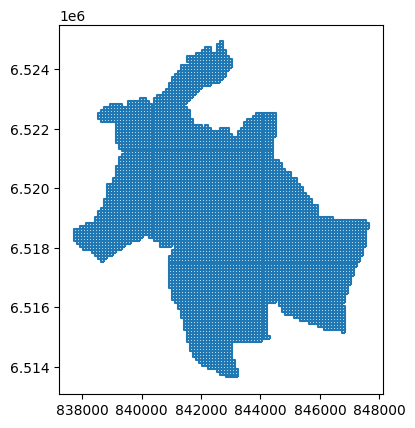

In [4]:
lyon_grid.boundary.plot()

In [48]:
gdf = ox.geocode_to_gdf("Lyon,France")
paris_espg = make_grid.get_epsg("lyon,france")
gdf = gdf.to_crs(epsg=paris_espg)

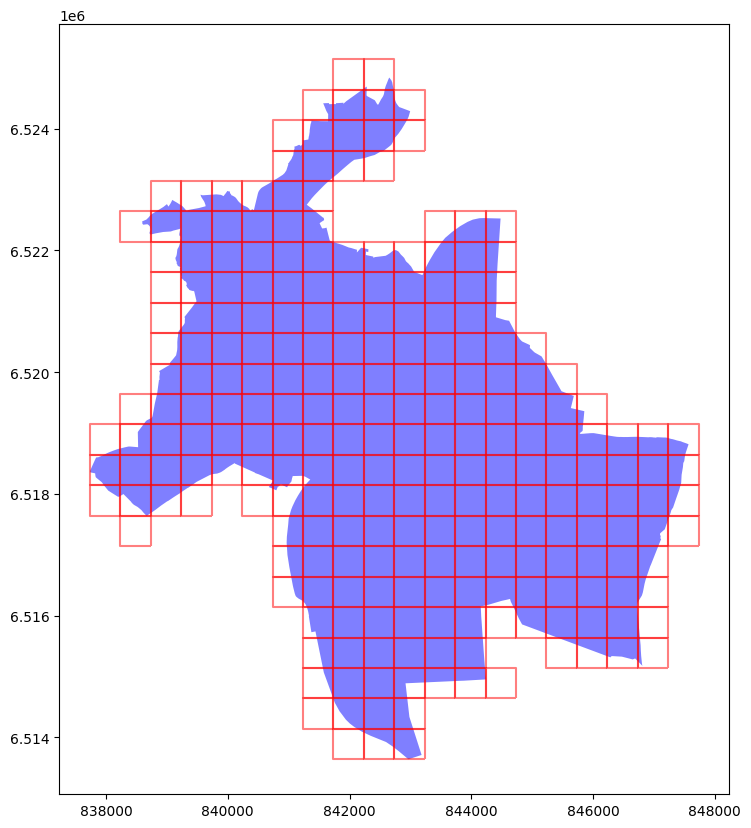

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', alpha=0.5)  # Plot city in blue
lyon_grid.boundary.plot(ax=ax, color='red', alpha=0.5)  # Plot grid in red
plt.show()

In [50]:
import ee
import osmnx as ox
import geopandas as gpd
import pandas as pd
import json

In [51]:
# # 1. Load boundaries and good format
# gdf = ox.geocode_to_gdf("Lyon,France")
# geometry_coords  = gdf.geometry.iloc[0].__geo_interface__
# # 2. Define Earth Engine geometry
# ee_geom = ee.Geometry.Polygon(geometry_coords['coordinates'])

In [52]:
import ee
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape

# Initialize Earth Engine
ee.Initialize(project='ee-thomasbaptiste45')  # Replace with your project ID

# Load grid file (EPSG:2154 or similar)
grid_gdf = gpd.read_file('data/grids/grid_lyon.geojson')
grid_gdf = grid_gdf.to_crs(epsg=4326)  # EE needs lat/lon (EPSG:4326)

# Convert geometries to EE features
def gdf_to_ee_features(gdf):
    features = []
    for idx, row in gdf.iterrows():
        geom = row.geometry.__geo_interface__
        ee_geom = ee.Geometry(geom)
        features.append(ee.Feature(ee_geom, {'id': str(idx)}))
    return ee.FeatureCollection(features)

# Define EE grid
ee_grid = gdf_to_ee_features(grid_gdf)




In [53]:
# Function to process image to key features
def process_image(img: ee.image) -> ee.Image: 
    # Convert ST_B10 to LST in Kelvin
    lst = img.select('ST_B10').multiply(0.00341802).add(149.0).rename('LST')
    lst = lst.subtract(273.15)
    #extract NDVI (vegetation)
    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    date = img.date().format("YYYY-MM-dd")
    return lst.addBands(ndvi).set('date',date)

collection = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(ee_grid.geometry())
    .filterDate('2021-01-01', '2021-12-31')
    .filter(ee.Filter.lt('CLOUD_COVER', 10))
)

# Get the processed image
processed = collection.map(process_image)

In [54]:
# Get list of processed images
image_list = processed.toList(processed.size())
num_images = processed.size().getInfo()

In [55]:
print(num_images)

8


In [56]:
# Split the grid into smaller chunks (subsets)
def split_city_grid(collection, max_size=5000):
    # Split the FeatureCollection into smaller collections to avoid 5000 element limit
    num_chunks = (collection.size().getInfo() // max_size) + 1
    chunks = []
    for i in range(num_chunks):
        start = i * max_size
        end = (i + 1) * max_size
        chunk = collection.toList(collection.size()).slice(start, end)
        chunks.append(ee.FeatureCollection(chunk))
    return chunks

# Split the grid into smaller chunks
ee_grid_chunks = split_city_grid(ee_grid, max_size=5000)

# List to hold all the results from each chunk
gdf_list = []

# Loop over all images
for i in range(num_images):
    img = ee.Image(image_list.get(i))
    date_str = img.get('date').getInfo()  # Retrieve image date string

    # Process each chunk separately
    for chunk in ee_grid_chunks:
        zonal_stats = img.reduceRegions(
            collection=chunk,
            reducer=ee.Reducer.mean(),
            scale=100,
        )
        
        # Get results as a list of dictionaries
        results = zonal_stats.getInfo()
        
        # Extract into DataFrame
        for feature in results['features']:
            geometry = shape(feature['geometry'])  # Convert GeoJSON to Shapely geometry
            properties = feature['properties']
            properties['date'] = date_str
            # Add image statistics to properties (LST, NDVI, etc.)
            properties['geometry'] = geometry
            
        # Create a GeoDataFrame-friendly dict and append to list
            gdf_list.append(properties)





In [57]:
# Now build GeoDataFrame
gdf = gpd.GeoDataFrame(gdf_list, geometry='geometry', crs='EPSG:4326')
# project back to city espg
gdf = gdf.to_crs('EPSG:2154')

<Axes: >

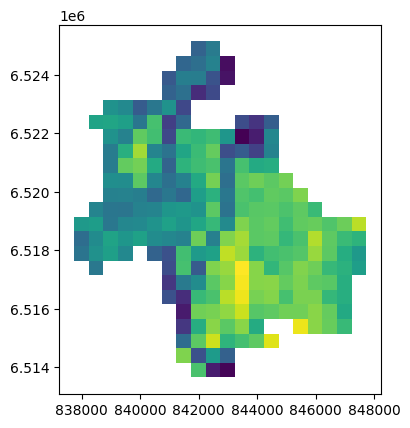

In [58]:
gdf[gdf['date']=="2021-07-20"].plot('LST')

In [59]:
# GET REFERENCE RURAL LST for each date of the dataset
def extract_rural_reference(city_geom_ee, buffer_km, start_date, end_date):
    """
    Extract mean rural LST around a city.
    Parameters:
    - city_geom_ee: ee.Geometry.Polygon of the city
    - processed: ee.ImageCollection with LST band
    - buffer_km: Buffer radius in kilometers

    Returns:
    - Mean rural LST (float)
    """
    # Step 1: Load land cover image and create rural mask (exclude urban = 50)
    landcover = ee.Image("ESA/WorldCover/v200/2021").select("Map")
    rural_mask = landcover.neq(50)  # non-urban = 1

    # Step 2: Create buffer around city geometry
    buffer_m = buffer_km * 1000
    buffer_geom = city_geom_ee.buffer(buffer_m)

    # Step 3: Remove the inner city to get only surrounding rural ring
    rural_area = buffer_geom.difference(city_geom_ee)

    # Step 4: Get mean LST image and apply rural mask
    def add_lst_band(img):
        lst = img.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15).rename('LST')
        date_str = img.date().format('YYYY-MM-dd')
        return lst.set('date', date_str)

    collection = (
        ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
        .filterBounds(buffer_geom)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUD_COVER', 10))
        .map(add_lst_band)
    )

    images = collection.toList(collection.size())
    n_images = images.size().getInfo()

    rural_lst_by_date = []

    for i in range(n_images):
        image = ee.Image(images.get(i))
        date = image.get('date').getInfo()
        masked = image.updateMask(rural_mask)

        mean = masked.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=rural_area,
            scale=100,
            maxPixels=1e13
        )

        mean_lst = mean.getInfo().get('LST')
        if mean_lst is not None:
            rural_lst_by_date.append({'date': date, 'LST': mean_lst})

    return rural_lst_by_date

In [60]:
rural_lst = extract_rural_reference(ee_grid.geometry(), 10, '2021-01-01', '2021-12-31')

In [61]:
rural_lst = pd.DataFrame(rural_lst)

In [62]:
rural_lst


,date,LST
0,2021-02-26,16.782601
1,2021-03-30,24.629782
2,2021-07-20,33.659677
3,2021-08-21,32.342109
4,2021-09-06,33.512437
5,2021-10-24,16.212135
6,2021-02-17,10.481808
7,2021-09-13,30.200260


In [63]:
# Get the unique rural LST for the specific date
for dates in rural_lst["date"]:
    rural_lst_value = rural_lst.loc[rural_lst["date"] == dates, "LST"].values[0]

    # Filter urban data for the same date
    urban_lsts = gdf.loc[gdf["date"] == dates, "LST"].values

    # Subtract the rural LST from each urban LST for that date
    lst_difference = urban_lsts - rural_lst_value

    gdf.loc[gdf["date"] == dates, "LST_anomaly"] = lst_difference

In [64]:
gdf.head()

,LST,NDVI,id,date,geometry,LST_anomaly
0,16.390087,0.168147,0,2021-02-26,"POLYGON ((838234.667 6517640.458, 838234.667 6...",-0.392514
1,15.898551,0.145651,1,2021-02-26,"POLYGON ((838234.667 6518140.458, 838234.667 6...",-0.884050
2,16.767284,0.129682,2,2021-02-26,"POLYGON ((838234.667 6518640.458, 838234.667 6...",-0.015317
3,16.772739,0.191425,3,2021-02-26,"POLYGON ((838734.667 6517140.458, 838734.667 6...",-0.009862
4,17.533413,0.152769,4,2021-02-26,"POLYGON ((838734.667 6517640.458, 838734.667 6...",0.750813


<Axes: >

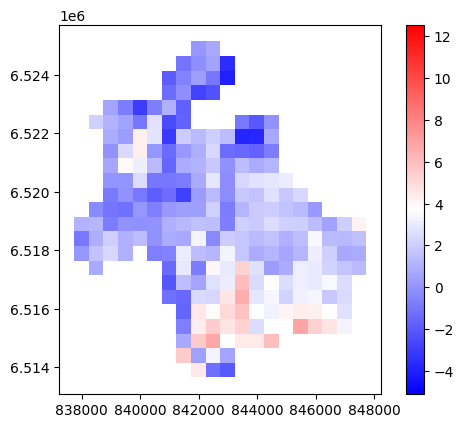

In [31]:
gdf.plot("LST_anomaly", cmap="bwr", legend=True)

In [66]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0)
gdf['cluster'] = kmeans.fit_predict(gdf[['LST_anomaly']])

In [37]:
gdf.head()

,LST,NDVI,id,date,geometry,LST_anomaly,cluster
0,16.390087,0.168147,0,2021-02-26,"POLYGON ((838234.667 6517640.458, 838234.667 6...",-0.392514,0
1,15.898551,0.145651,1,2021-02-26,"POLYGON ((838234.667 6518140.458, 838234.667 6...",-0.884050,0
2,16.767284,0.129682,2,2021-02-26,"POLYGON ((838234.667 6518640.458, 838234.667 6...",-0.015317,0
3,16.772739,0.191425,3,2021-02-26,"POLYGON ((838734.667 6517140.458, 838734.667 6...",-0.009862,0
4,17.533413,0.152769,4,2021-02-26,"POLYGON ((838734.667 6517640.458, 838734.667 6...",0.750813,0


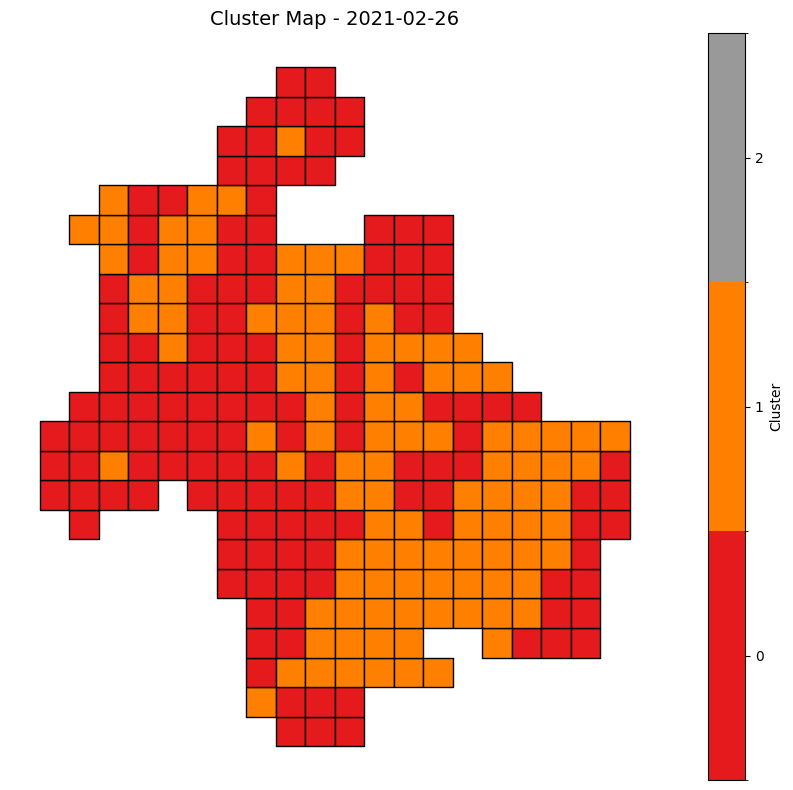

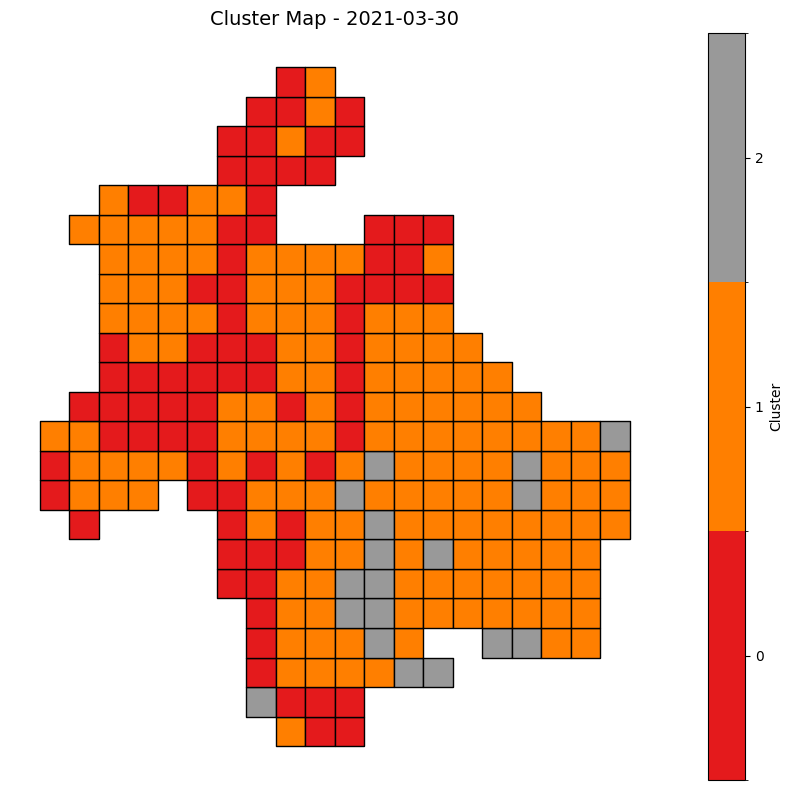

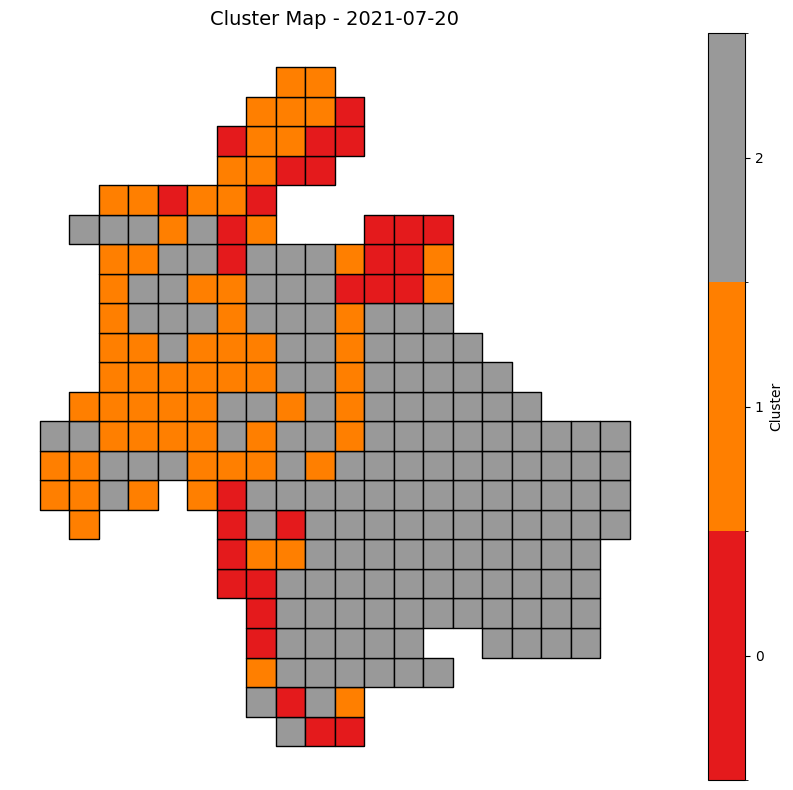

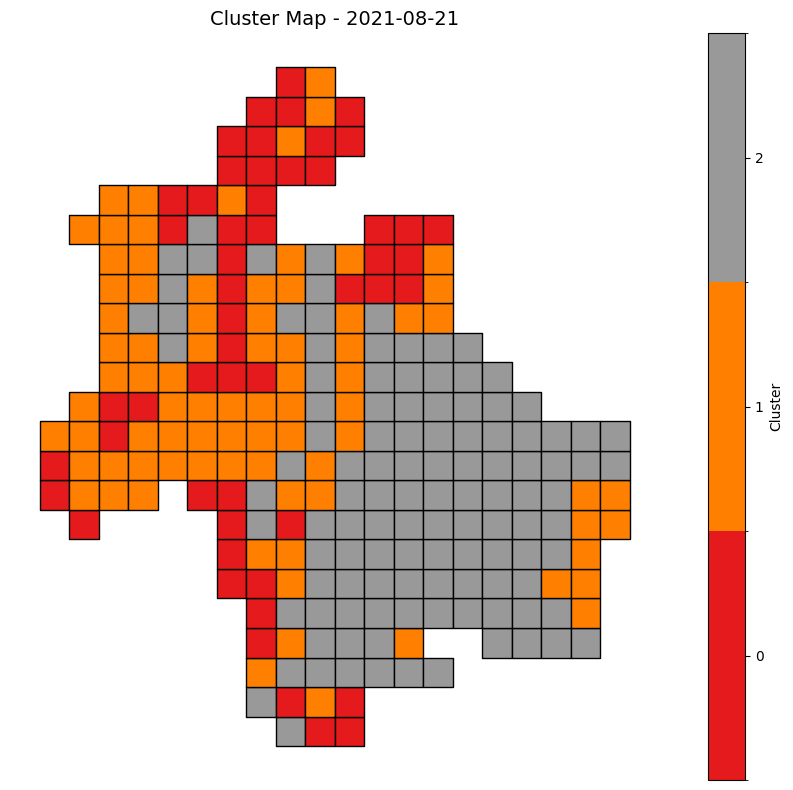

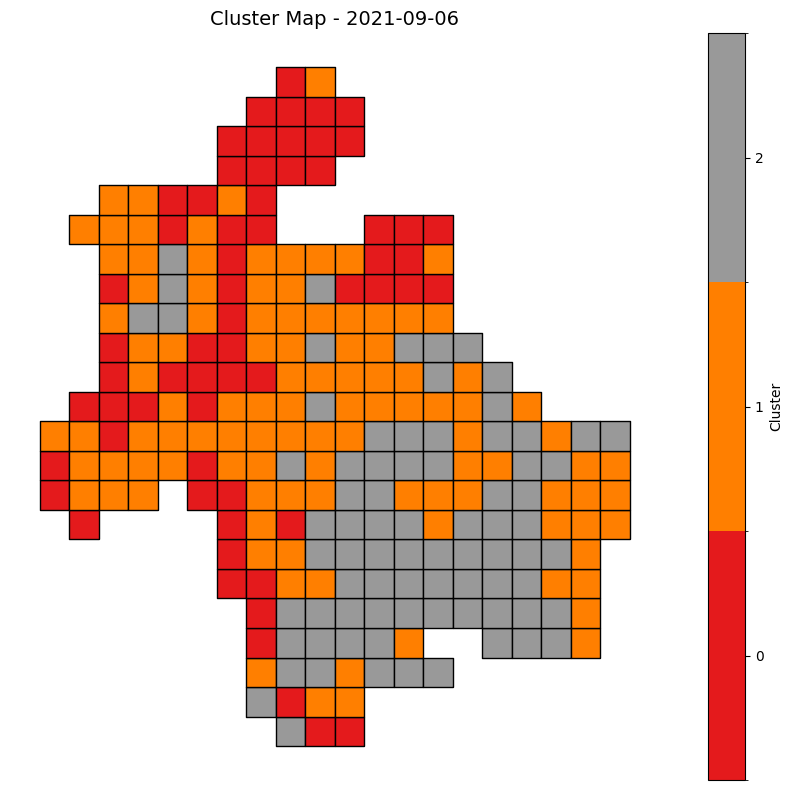

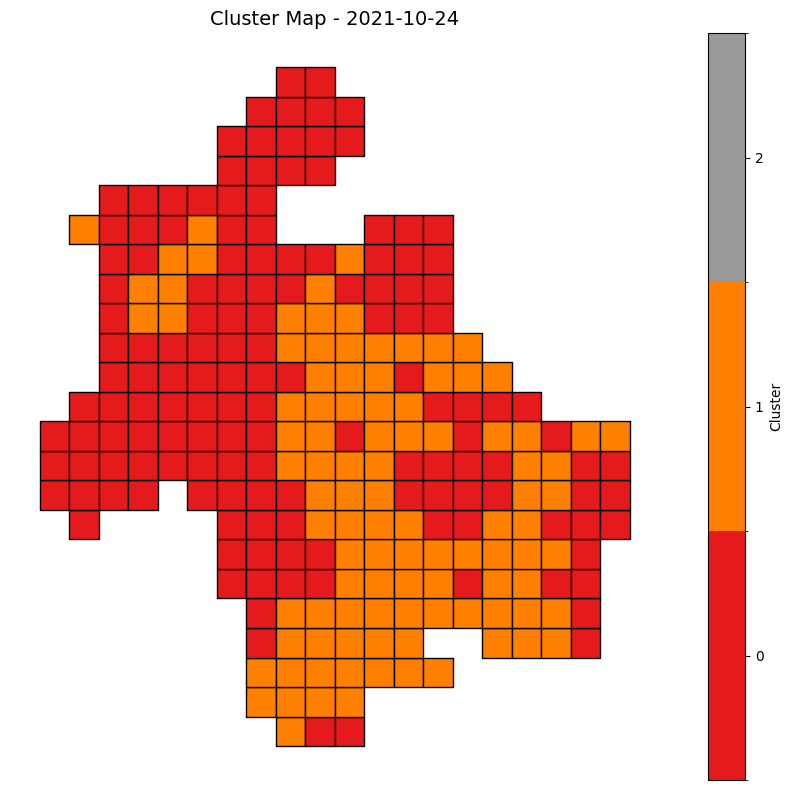

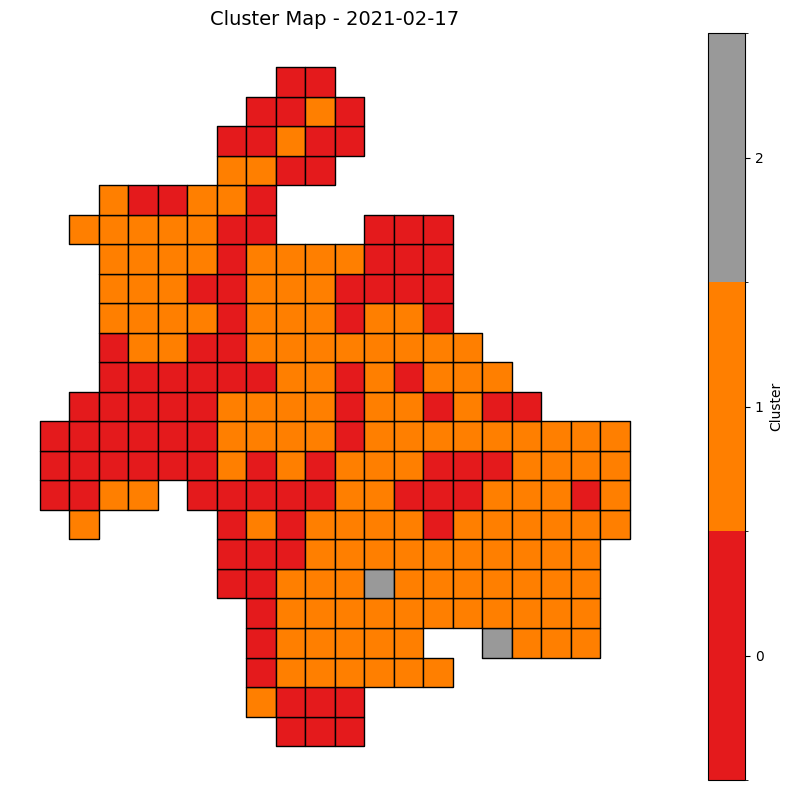

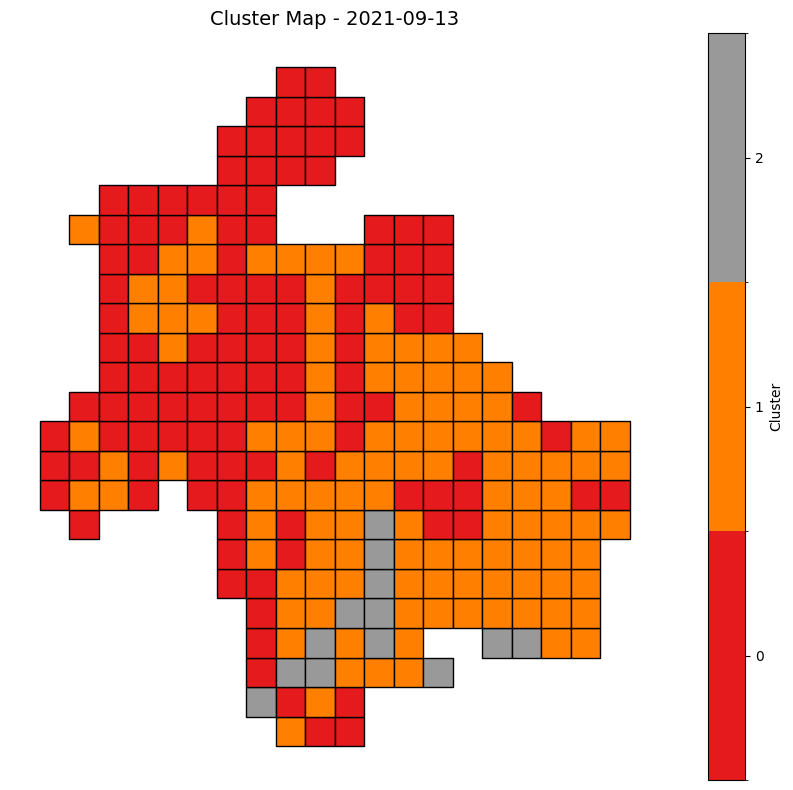

In [70]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure dates are in datetime format
gdf['date'] = pd.to_datetime(gdf['date'])
unique_dates = gdf['date'].dt.date.unique()

# Optional: define the range of clusters
cluster_labels = sorted(gdf['cluster'].unique())  # e.g., [0, 1, 2]

for date in unique_dates:
    subset = gdf[gdf['date'].dt.date == date]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Create a discrete colormap
    cmap = plt.get_cmap('Set1', len(cluster_labels))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(cluster_labels)+0.5, 1), ncolors=len(cluster_labels))
    
    # Plot and get the colorbar
    plot = subset.plot(column='cluster', ax=ax, cmap=cmap, norm=norm, edgecolor='black')
    
    # Manually create colorbar with set ticks
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # dummy array for ScalarMappable
    cbar = fig.colorbar(sm, ax=ax, ticks=cluster_labels)
    cbar.set_label("Cluster")
    
    ax.set_title(f"Cluster Map - {date}", fontsize=14)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [35]:
# Save to GeoJSON file
gdf.to_file('data/processed/lyon_data_test.geojson', driver='GeoJSON')

In [36]:
gdf["LST"].min()

np.float64(6.699023685563595)